In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch 
from src import tokenize
from CustomDatasets.PeptidesWithRetentionTimes import PeptidesWithRetentionTimes
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [18]:
df = pd.read_csv(r"C:\\Users\\elabo\\Documents\\MannPeptideResults\\CalibratorTestingMultipleFilesSmallFiltered.csv")
fullSequence_retentionTimeAvg_df = df[['FullSequence', 'Mean']]

train_df, test_df = train_test_split(fullSequence_retentionTimeAvg_df, test_size=0.2, random_state=42, shuffle=True)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, shuffle=True)
train_df.to_csv(r"trypsin_train_set.csv", index=False)
test_df.to_csv(r"trypsin_test_set.csv", index=False)
val_df.to_csv(r"trypsin_val_set.csv", index=False)


In [19]:
train_df, test_df, val_df

(                                             FullSequence        Mean
 196821                                         GGQVYATNTR   23.613440
 6096                                    SQVFSTAADGQTQVEIK   68.222373
 98887                                           QFAALVASK   47.242717
 197496              GLAGGAALLSE[Metal:Cu[I] on E]WKGTGPGK  117.777690
 94287   VIHDN[Common Artifact:Ammonia loss on N]FGIVE[...  164.517150
 ...                                                   ...         ...
 119879                                   RQVLLSAAEAAEVILR  177.456603
 103694  WN[Common Biological:Hydroxylation on N]GHTDM[...   74.850930
 131932       VSGAQEM[Common Variable:Oxidation on M]VSSAK   17.015732
 146867                                            THVGSYK   11.407020
 121958                                      WVEQHLGPQFVER   81.213750
 
 [168844 rows x 2 columns],
                                         FullSequence        Mean
 118828                             IEATYESVLFHQLQEI

In [20]:
class TunableAttentionRegression(torch.nn.Module):
    def __init__(self, input_size = 2707, hidden_size = 64,
                output_size = 1, numberOfHeads = 16) -> None:
        super(TunableAttentionRegression, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, 32)
        self.lstm = torch.nn.LSTM(32, hidden_size, batch_first=True)
        self.attention = torch.nn.MultiheadAttention(hidden_size, num_heads=numberOfHeads, batch_first=True) #https://pytorch.org/docs/stable/generated/torch.ao.nn.quantizable.MultiheadAttention.html#multiheadattention
        self.linear1 = torch.nn.Linear(hidden_size*200, output_size, dtype=torch.float32)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x) -> torch.Tensor:
        # print(x.shape)
        x = x.view(x.size(0), x.size(2)*2)
        # print(x.shape)
        embedded = self.embedding(x)
        # print(embedded.shape)
        # embedded = embedded.view(*x.size(), -1) #to make it 3D
        lstm_out, _ = self.lstm(embedded)
        # print(lstm_out.shape)
        # lstm_out = lstm_out.permute(1, 0, 2)  # [seq_len, batch, hidden_size]
        # print(lstm_out.shape)
        query = lstm_out.permute(0, 1, 2)
        key = lstm_out.permute(0, 1, 2)
        value = lstm_out.permute(0, 1, 2)
        # print(query.shape, key.shape, value.shape)
        attention_output, _ = self.attention(query, key, value)
        # print(attention_output.shape)
        attention_output_as_2d = attention_output.reshape(attention_output.size(0), attention_output.size(1)*attention_output.size(2))
        # print(attention_output_as_2d.shape)
        output = self.linear1(attention_output_as_2d)
        # print(output.shape)
        # print(output)
        return output

In [21]:
vocab = tokenize.readVocabulary("C:\\Users\\elabo\\Documents\\GitHub\\RetentionTimeEstimators\\vocab.csv")
training_data = pd.read_csv(r"trypsin_train_set.csv", index_col=None, header=0, usecols=["FullSequence", "Mean"])
testing_data = pd.read_csv(r"trypsin_test_set.csv", index_col=None, header=0, usecols=["FullSequence", "Mean"])
validation_data = pd.read_csv(r"trypsin_val_set.csv", index_col=None, header=0, usecols=["FullSequence", "Mean"])

trainingTokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(training_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)
testingTokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(testing_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)
validationTokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(validation_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)

trainingSequences = []
trainingRetentionTimes = []
for i in trainingTokens:
    trainingSequences.append(i[0])
    trainingRetentionTimes.append(i[1])

validationSequences = []
validationRetentionTimes = []
for i in validationTokens:
    validationSequences.append(i[0])
    validationRetentionTimes.append(i[1])

testingSequences = []
testingRetentionTimes = []
for i in testingTokens:
    testingSequences.append(i[0])
    testingRetentionTimes.append(i[1])

trainingDataset = PeptidesWithRetentionTimes(trainingSequences, trainingRetentionTimes)
testingDataset = PeptidesWithRetentionTimes(testingSequences, testingRetentionTimes)
validationDataset = PeptidesWithRetentionTimes(validationSequences, validationRetentionTimes)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[1]))
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.

In [22]:
len(trainingDataset), len(testingDataset), len(validationDataset)

(131641, 16276, 16423)

In [23]:
#training data/ validation data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model
model = TunableAttentionRegression(hidden_size=64, numberOfHeads=8).to(device)
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Create the loss function
criterion = torch.nn.MSELoss().to(device)

# Create the training data loader
trainingDataLoader = torch.utils.data.DataLoader(trainingDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

validationDataLoader = torch.utils.data.DataLoader(validationDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

testinDataLoader = torch.utils.data.DataLoader(testingDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

c:\Users\elabo\anaconda3\envs\RTPy39\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [24]:
# Train the model
model.train()
epochs = 100
validationLoss = []
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainingDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs[:,0].shape, labels.shape)
        outputs = model(inputs.to(device)).to(device).squeeze()
        # print(outputs, labels.shape)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.5f" % (epoch + 1, i + 1,
                                            running_loss / epoch_steps))
            running_loss = 0.0

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(validationDataLoader):
        with torch.no_grad():
            inputs, labels = data
            labels = labels.float()

            outputs = model(inputs.to(device)).to(device).squeeze()
            total += labels.size(0)
            correct += (outputs.to(device) == labels.to(device)).sum().item()

            loss = criterion(outputs.to(device), labels.to(device))
            val_loss += loss.cpu().numpy()
            val_steps += 1
    validationLoss.append(val_loss)
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}, Loss: {val_loss:.5f}')

model.eval()
#save the model 
torch.save(model.state_dict(), "trypsin_lsm_attention_{}.pt".format(epochs))

[1,  2000] loss: 482.09897
[1,  4000] loss: 145.54811
Epoch 1, Loss: 128083.93376
[2,  2000] loss: 269.56770
[2,  4000] loss: 129.63411
Epoch 2, Loss: 129321.42670
[3,  2000] loss: 256.51020
[3,  4000] loss: 124.08021
Epoch 3, Loss: 114797.42453
[4,  2000] loss: 244.65992
[4,  4000] loss: 122.55700
Epoch 4, Loss: 139786.58435
[5,  2000] loss: 240.05047
[5,  4000] loss: 119.92111
Epoch 5, Loss: 110579.08727
[6,  2000] loss: 277.22882
[6,  4000] loss: 113.45197
Epoch 6, Loss: 107902.57315
[7,  2000] loss: 228.97847
[7,  4000] loss: 117.53224
Epoch 7, Loss: 109675.60175
[8,  2000] loss: 229.21651
[8,  4000] loss: 118.40137
Epoch 8, Loss: 123081.12148
[9,  2000] loss: 225.25738
[9,  4000] loss: 117.66592
Epoch 9, Loss: 110522.29269
[10,  2000] loss: 228.81889
[10,  4000] loss: 114.66100
Epoch 10, Loss: 110006.55167
[11,  2000] loss: 209.26253
[11,  4000] loss: 100.57302
Epoch 11, Loss: 116506.60806
[12,  2000] loss: 191.39469
[12,  4000] loss: 106.71292
Epoch 12, Loss: 100473.09126
[13,  2

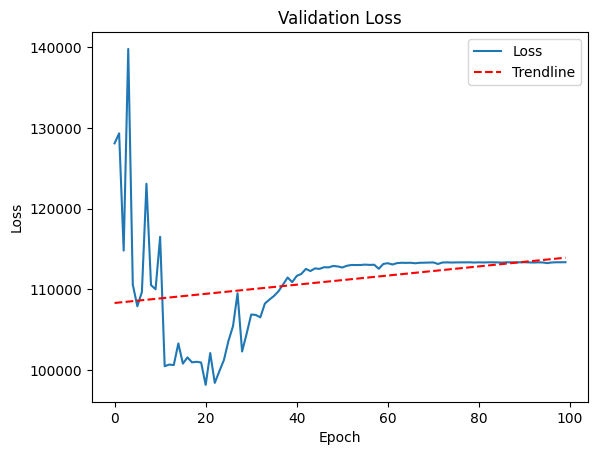

In [25]:
#visualize the loss
plt.plot(validationLoss)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#trendline
z = np.polyfit(range(0, epochs), validationLoss, 1)
p = np.poly1d(z)
plt.plot(range(0, epochs), p(range(0, epochs)), "r--")
plt.legend(["Loss", "Trendline"])
plt.show()

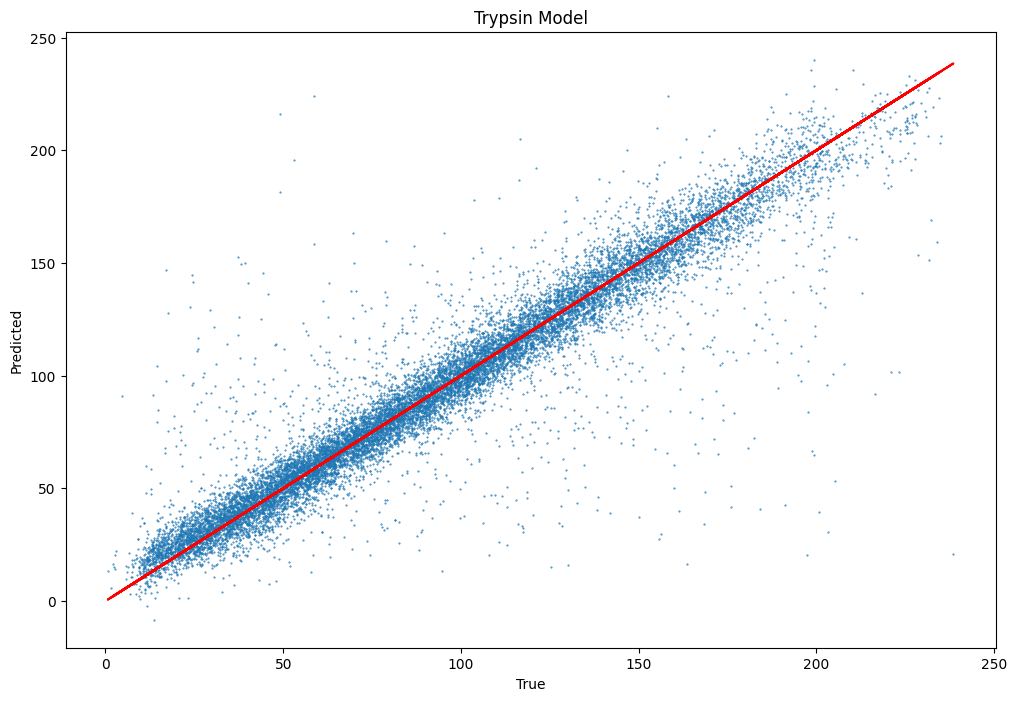

In [27]:
#Test model and get accuracy
testinDataLoader = torch.utils.data.DataLoader(testingDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)
test_loss = 0.0
test_steps = 0
total = 0
correct = 0
# model.load_state_dict(torch.load('secondTry_model_hs_32_epoch_5.pt'))
model.eval()
preds = []

# Test model and calculate accuracy
for i, data in enumerate(testinDataLoader):
    with torch.no_grad():
        inputs, labels = data

        outputs = model(inputs.to(device)).to(device)
        predicted = outputs
        preds.append((labels, predicted))

allPredictions = []
allLabels = []
for label, pred in preds:
    allPredictions.append(pred)
    allLabels.append(label)

flatPreds = torch.stack(allPredictions).tolist()
flatLabels = torch.stack(allLabels).tolist()

# Plot the results
#title
plt.title("Trypsin Model")
#scatter plot
plt.scatter(flatLabels, flatPreds, s=0.2)
plt.plot(flatLabels, flatLabels, color='red')
#labels
plt.xlabel("True")
plt.ylabel("Predicted")
#increase plot size 
plt.gcf().set_size_inches(12, 8)
#show plot
plt.show()